In [1]:
import jax
import jax.numpy as jnp
from jax import lax
from jax import random
import numpy as np
import math
from flax import linen as nn
from flax.linen.initializers import constant, ones, zeros
import optax
from flax.training.train_state import TrainState
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Preprocessing The Data

In [3]:
df1 = pd.read_csv("hf://datasets/FrancophonIA/Fon_French_Daily_Dialogues_Parallel_Data/train.csv")

In [4]:
df1.head()

,Fon_Sentence,French_Translation
0,é ɖò ayìjúnjɔ́n,elle est assis
1,mí ɖò ayìjúnjɔ́n,nous sommes assis
2,e ɖo azɔmɛ,elle est à l'école
3,mí ɖo azɔmɛ,nous sommes à l'école
4,e ɖo xwe gbe,elle est à la maison


In [5]:
# Split on train and test
train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)

In [6]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train2 = pd.read_parquet("hf://datasets/beethogedeon/fr_fon/" + splits["train"])

In [7]:
test2 = pd.read_parquet("hf://datasets/beethogedeon/fr_fon/" + splits["test"])

In [18]:
# Instead of using .list()
fon_train1 = train1["Fon_Sentence"].tolist()
fr_train1 = train1["French_Translation"].tolist()

fon_train2 = train2["fon"].tolist()
fr_train2 = train2["french"].tolist()

# Then concatenate the lists
fon_train = fon_train1 #+ fon_train2
fr_train = fr_train1 #+ fr_train2

In [19]:
fon_test1 = test1["Fon_Sentence"].tolist()
fr_test1 = test1["French_Translation"].tolist()

fon_test2 = test2["fon"].tolist()
fr_test2 = test2["french"].tolist()

# Then concatenate the lists
fon_test = fon_test1  #+ fon_test2
fr_test = fr_test1  #+ fr_test2

In [20]:
# Determine the max length of the sentences
max_len_fon = max([len(i.split(" ")) for i in fon_train])
max_len_fr = max([len(i.split(" ")) for i in fr_train])

Visualization

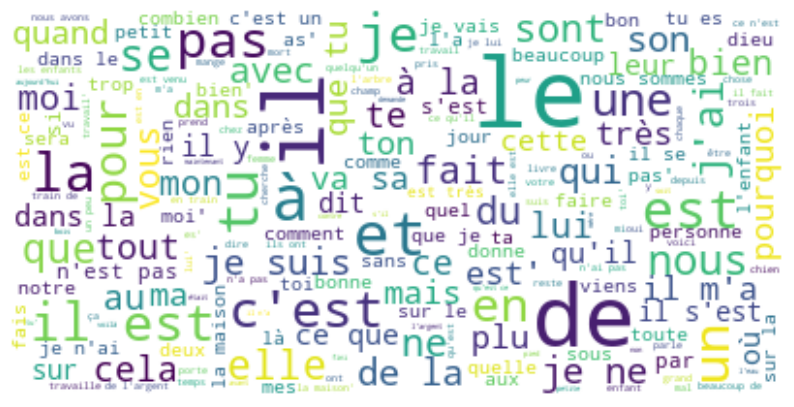

In [14]:
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(str(fr_test))

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

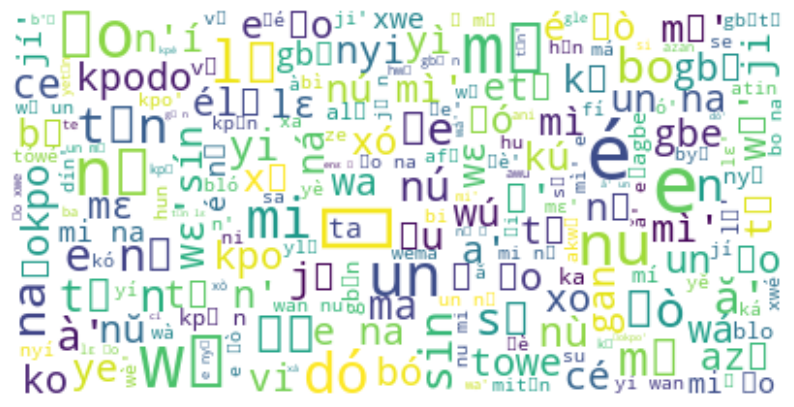

In [15]:
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(str(fon_test))

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [16]:
for i in range(len(fon_train)):
    fon_train[i] = "sos " + str(fon_train[i]) + " eos."
    fr_train[i] = "sos " + str(fr_train[i]) + " eos."

for i in range(len(fon_test)):
    fon_test[i] = "sos " + str(fon_test[i]) + " eos."
    fr_test[i] = "sos " + str(fr_test[i]) + " eos."

In [17]:
fr = fr_train + fr_test
fon = fon_train + fon_test

Tokenization

In [23]:
# Count num of words
fr_words = []
for i in fr:
    fr_words.extend(i.split(" "))

fon_words = []
for i in fon:
    fon_words.extend(i.split(" "))

fr_words = list(set(fr_words))
fon_words = list(set(fon_words))

len_fr_words = len(fr_words)
len_fon_words = len(fon_words)

print(len_fr_words, len_fon_words)

20197 12354


Tokenization

In [24]:
tokenizer_fon = Tokenizer(num_words=len_fon_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_fon.fit_on_texts(fon)

word_index = tokenizer_fon.word_index
print(f"The number of words in the Fon vocabulary: {len(word_index)}")

The number of words in the Fon vocabulary: 11276


In [25]:
tokenizer_fr = Tokenizer(num_words=len_fr_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_fr.fit_on_texts(fr)

word_index_fr = tokenizer_fr.word_index
print(f"The number of words in the French vocabulary: {len(word_index_fr)}")

The number of words in the French vocabulary: 18012


In [26]:
# Tokenize the sequences
fon_sequences_train = tokenizer_fon.texts_to_sequences(fon_train)
fr_sequences_train = tokenizer_fr.texts_to_sequences(fr_train)

fon_sequences_test = tokenizer_fon.texts_to_sequences(fon_test)
fr_sequences_test = tokenizer_fr.texts_to_sequences(fr_test)

Padding

In [27]:
fon_sequences_train = pad_sequences(fon_sequences_train, maxlen = 60, padding='post', truncating='post')
fr_sequences_train = pad_sequences(fr_sequences_train, maxlen = 60, padding='post', truncating='post')

fon_sequences_test = pad_sequences(fon_sequences_test, maxlen = 60, padding='post', truncating='post')
fr_sequences_test = pad_sequences(fr_sequences_test, maxlen = 60, padding='post', truncating='post')


In [28]:
# Convert sequences to JAX arrays
fon_sequences_train = jnp.array(fon_sequences_train)
fr_sequences_train = jnp.array(fr_sequences_train)
fon_sequences_test = jnp.array(fon_sequences_test)
fr_sequences_test = jnp.array(fr_sequences_test)

# Create proper data loader with batches
def create_batches(inputs, targets, batch_size):
    dataset_size = len(inputs)
    indices = jnp.arange(dataset_size)
    # Shuffle the indices
    indices = jax.random.permutation(jax.random.PRNGKey(0), indices)

    for i in range(0, dataset_size, batch_size):
        batch_indices = indices[i:i+batch_size]
        yield jnp.take(inputs, batch_indices, axis=0), jnp.take(targets, batch_indices, axis=0)

Multi-Head Attention

In [29]:
class DyT(nn.Module):
    """Dynamic Tanh (DyT) normalization layer.

    This layer performs normalization using a learnable scaled tanh activation
    followed by an affine transformation (weight * x + bias).

    Attributes:
        num_features: Number of features/channels to normalize
        alpha_init: Initial value for the tanh scaling parameter (default: 0.5)
    """
    num_features: int
    alpha_init: float = 0.5

    @nn.compact
    def __call__(self, x):
        #Learnable scaling parameter for tanh activation
        alpha = self.param('alpha', constant(self.alpha_init), ())  # Scalar parameter

        # Affine transformation parameters (similar to BatchNorm)
        weight = self.param('weight', ones, (self.num_features,))    # Scale parameter
        bias = self.param('bias', zeros, (self.num_features,))       # Shift parameter
        # Apply scaled tanh activation
        # constrains values between -1 and 1 while alpha controls steepness
        normalized = nn.tanh(alpha * x)

        # Apply affine transformation (channel-wise scaling and shifting)
        return normalized * weight + bias

In [30]:
class MultiHeadAttention(nn.Module):
    layer: int = 6
    mlp_dim: int = 2048
    feature: int = 512
    length: int = 30
    num_heads: int = 8
    batch_size: int = 64
    head_dim: int = None
    use_bias: bool = False
    dropout_rate: float = 0.2
    training: bool = False
    seed: int = 0
    decode: bool = False
    dtype: jnp.dtype = jnp.float32

    def __post_init__(self):
        if self.head_dim is None:
            object.__setattr__(self, 'head_dim', self.feature // self.num_heads)
        super().__post_init__()

    @nn.compact
    def __call__(self, kv, q, mask=None):
        batch_size = q.shape[0]  # Get dynamic batch size from input

        # Projections
        query = nn.Dense(self.feature, use_bias=self.use_bias)(q)
        key = nn.Dense(self.feature, use_bias=self.use_bias)(kv)
        value = nn.Dense(self.feature, use_bias=self.use_bias)(kv)

        # Apply DyT normalization - keep as is
        query = DyT(self.feature)(query)
        key = DyT(self.feature)(key)
        value = DyT(self.feature)(value)

        # Reshape for multi-head attention - use dynamic batch size
        query = query.reshape((batch_size, -1, self.num_heads, self.head_dim))
        key = key.reshape((batch_size, -1, self.num_heads, self.head_dim))
        value = value.reshape((batch_size, -1, self.num_heads, self.head_dim))

        # Compute attention with numerical stability
        attention_output = self._scaled_dot_product_attention(key, query, value, mask)

        # Reshape back - use dynamic batch size
        attention_output = attention_output.reshape((batch_size, -1, self.feature))

        # Final projection
        output = nn.Dense(self.feature, use_bias=self.use_bias)(attention_output)
        output = nn.Dropout(rate=self.dropout_rate)(output, deterministic=not self.training)

        return output

    def _scaled_dot_product_attention(self, key, query, value, mask=None):
        # Calculate attention scores with proper shape alignment
        attention_scores = jnp.einsum("bqhd,bkhd->bhqk", query, key)

        # Scale attention scores with proper numerical handling
        dk = jnp.sqrt(jnp.array(query.shape[-1], dtype=self.dtype))
        attention_scores = attention_scores / dk

        # Apply mask if provided (using proper mask format)
        if mask is not None:
            attention_scores = attention_scores + mask

        # Apply softmax with stable numeric handling
        attention_weights = jax.nn.softmax(attention_scores, axis=-1)

        # Calculate output
        return jnp.einsum('bhqk,bkhd->bqhd', attention_weights, value)

Mask

In [31]:
def attention_mask(input_tokens):
    # Create a proper padding mask (1 for values that should be masked)
    mask = (input_tokens == 0)
    # Expand dimensions for broadcasting with attention weights
    mask = jnp.expand_dims(jnp.expand_dims(mask, axis=1), axis=1)
    # Convert to float32 and set masked positions to -1e9 (close to -inf)
    mask = jnp.where(mask, -1e9, 0.0)
    return mask

def causal_mask(length):
    # Create causal mask (lower triangular)
    mask = 1 - jnp.triu(jnp.ones((length, length)), k=1)
    # Convert to float32 and set masked positions to -1e9
    mask = jnp.where(mask == 0, -1e9, 0.0)
    return mask

Feed Forward

In [32]:
class MLP(nn.Module):
    mlp_dim : int = 2048
    feature : int = 512
    use_bias: bool = False
    dropout_rate: float = 0.2
    training: bool = False

    @nn.compact
    def __call__(self, x):
        # mlp_dim*4 to increase knowledge by 4 times
        x = nn.Dense(features=self.mlp_dim*4, use_bias=self.use_bias)(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not self.training)
        x = nn.relu(x)
        x = nn.Dense(features=self.feature, use_bias=self.use_bias)(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not self.training)
        return x

Encoder Layer

In [33]:
class Encoder(nn.Module):
    layer : int = 6
    mlp_dim : int = 2048
    feature : int = 512
    length : int = 30
    num_heads : int = 8
    batch_size : int = 64
    head_dim : int = mlp_dim // num_heads
    use_bias: bool = False
    dropout_rate: float = 0.2
    training: bool = False
    seed: int = 0

    @nn.compact
    def __call__(self, input_embeding, encoder_mask):
        # Encoder layer
        x = input_embeding
        for i in range(self.layer):
            # Multihead Attention
            y = MultiHeadAttention(layer=self.layer, mlp_dim=self.mlp_dim, feature=self.feature, length=self.length, num_heads=self.num_heads, batch_size=self.batch_size, head_dim=self.head_dim, use_bias=self.use_bias, dropout_rate=self.dropout_rate, training=self.training, seed=self.seed)(
                    kv=x,
                    q=x,
                    mask=encoder_mask
            )
            # Add & Norm
            y = y + x
            x = DyT(self.feature)(y)
            # MLP
            y = MLP(mlp_dim=self.mlp_dim, feature=self.feature, use_bias=self.use_bias, dropout_rate=self.dropout_rate, training=self.training)(x)
            # Add & Norm
            y = y + x
            x = DyT(self.feature)(y)

        return x

Decoder Layer

In [34]:
class Decoder(nn.Module):
    layer : int = 6
    mlp_dim : int = 2048
    feature : int = 512
    length : int = 30
    num_heads : int = 8
    batch_size : int = 64
    head_dim : int = mlp_dim // num_heads
    use_bias: bool = False
    dropout_rate: float = 0.2
    training: bool = False
    seed: int = 0


    @nn.compact
    def __call__(self, input_embeding, encoder_kv, decoder_mask, encoder_decoder_mask):
        # Decoder layer
        x = input_embeding
        for i in range(self.layer):
            # Multihead Attention
            y = MultiHeadAttention(layer=self.layer, mlp_dim=self.mlp_dim, feature=self.feature, length=self.length, num_heads=self.num_heads, batch_size=self.batch_size, head_dim=self.head_dim, use_bias=self.use_bias, dropout_rate=self.dropout_rate, training=self.training, seed=self.seed)(
                    kv=x,
                    q=x,
                    mask=decoder_mask,
            )
            # Add & Norm
            y = y + x
            x = DyT(self.feature)(y)
            # Cross Multihead-Attention
            y = MultiHeadAttention(layer=self.layer, mlp_dim=self.mlp_dim, feature=self.feature, length=self.length, num_heads=self.num_heads, batch_size=self.batch_size, head_dim=self.head_dim, use_bias=self.use_bias, dropout_rate=self.dropout_rate, training=self.training, seed=self.seed)(
                    kv=encoder_kv,
                    q=x,
                    mask=encoder_decoder_mask,
            )
            # Add & Norm
            y = y + x
            x = DyT(self.feature)(y)
            # MLP
            y = MLP(mlp_dim=self.mlp_dim, feature=self.feature, use_bias=self.use_bias, dropout_rate=self.dropout_rate, training=self.training)(x)
            # Add & Norm
            y = y + x
            x = DyT(self.feature)(y)

        return x

In [35]:
class Transformer(nn.Module):
    layer: int = 6
    mlp_dim: int = 2048
    feature: int = 512
    length: int = 30
    num_heads: int = 8
    batch_size: int = 64
    head_dim: int = None
    use_bias: bool = False
    dropout_rate: float = 0.2
    training: bool = False
    seed: int = 0
    src_vocab_size: int = None  # Add vocabulary sizes
    tgt_vocab_size: int = None

    def __post_init__(self):
        if self.head_dim is None:
            object.__setattr__(self, 'head_dim', self.feature // self.num_heads)
        super().__post_init__()

    @nn.compact
    def __call__(self, encoder_input_tokens, decoder_target_tokens):
        batch_size = encoder_input_tokens.shape[0]
        src_seq_len = encoder_input_tokens.shape[1]
        tgt_seq_len = decoder_target_tokens.shape[1]

        # Initialize masks correctly
        enc_padding_mask = attention_mask(encoder_input_tokens)
        dec_causal_mask = causal_mask(tgt_seq_len)

        # Source embedding - use correct vocab size
        src_embedding = nn.Embed(
                num_embeddings=self.src_vocab_size,
                features=self.feature
        )(encoder_input_tokens)

        # Target embedding - use correct vocab size
        tgt_embedding = nn.Embed(
                num_embeddings=self.tgt_vocab_size,
                features=self.feature
        )(decoder_target_tokens)

        # Encoder
        enc_output = Encoder(
                layer=self.layer,
                mlp_dim=self.mlp_dim,
                feature=self.feature,
                length=src_seq_len,
                num_heads=self.num_heads,
                batch_size=batch_size,
                head_dim=self.head_dim,
                use_bias=self.use_bias,
                dropout_rate=self.dropout_rate,
                training=self.training,
                seed=self.seed
        )(src_embedding, enc_padding_mask)

        # Decoder
        dec_output = Decoder(
                layer=self.layer,
                mlp_dim=self.mlp_dim,
                feature=self.feature,
                length=tgt_seq_len,
                num_heads=self.num_heads,
                batch_size=batch_size,
                head_dim=self.head_dim,
                use_bias=self.use_bias,
                dropout_rate=self.dropout_rate,
                training=self.training,
                seed=self.seed
        )(tgt_embedding, enc_output, dec_causal_mask, enc_padding_mask)

        # Final linear projection to vocabulary size
        logits = nn.Dense(features=self.tgt_vocab_size)(dec_output)

        return logits

Test Model

In [36]:
batch_size = 64

train_dataloader = lambda: create_batches(fon_sequences_train, fr_sequences_train, batch_size)
test_dataloader = lambda: create_batches(fon_sequences_test, fr_sequences_test, batch_size)

In [37]:
# Get vocabulary sizes
src_vocab_size = len(tokenizer_fon.word_index) + 1  # +1 for padding token
tgt_vocab_size = len(tokenizer_fr.word_index) + 1   # +1 for padding token

# Initialize model with correct vocab sizes
model = Transformer(
        src_vocab_size=src_vocab_size,
        tgt_vocab_size=tgt_vocab_size,
        feature=512,
        num_heads=8,
        layer=6,
        mlp_dim=2048,
        dropout_rate=0.1,
        training=True
)

# Initialize parameters with dropout key
random_seed = jax.random.PRNGKey(0)
dropout_seed = jax.random.PRNGKey(1)  # Separate key for dropout
batch = next(create_batches(fon_sequences_train, fr_sequences_train, 64))
encoder_input_tokens, decoder_target_tokens = batch
params = model.init(random_seed, encoder_input_tokens, decoder_target_tokens)

# Generate output with dropout RNG
output = model.apply(params, encoder_input_tokens, decoder_target_tokens, rngs={'dropout': dropout_seed})
print('Output shape:', output.shape)

Output shape: (64, 60, 18013)


Training a Transformer Model for Translation

In [38]:
# Define loss function (cross-entropy with label smoothing)
def cross_entropy_loss(logits, labels, label_smoothing=0.1):
    vocab_size = logits.shape[-1]
    confidence = 1.0 - label_smoothing
    low_confidence = label_smoothing / (vocab_size - 1)

    # Create smoothed one-hot targets
    soft_targets = jax.nn.one_hot(labels, vocab_size)
    soft_targets = soft_targets * confidence + low_confidence * (1.0 - soft_targets)

    # Create mask for padding tokens
    padding_mask = (labels > 0).astype(jnp.float32)

    # Calculate cross-entropy loss
    loss = -jnp.sum(soft_targets * jax.nn.log_softmax(logits, axis=-1), axis=-1)

    # Apply mask and normalize
    loss = jnp.sum(loss * padding_mask) / jnp.sum(padding_mask)
    return loss

In [39]:
# Set up optimizer with learning rate scheduler
def create_learning_rate_scheduler(base_learning_rate=0.0001,
                                   warmup_steps=4000):
    """Creates a learning rate scheduler with warmup and decay."""
    def schedule(step):
        # Linear warmup followed by decay
        warmup_factor = jnp.minimum(1.0, step / warmup_steps)
        decay_factor = 1.0 / jnp.sqrt(jnp.maximum(step, warmup_steps))
        return base_learning_rate * warmup_factor * decay_factor

    return schedule

In [40]:
# Define training state
def create_train_state(rng, model, learning_rate_fn):
    """Creates initial training state."""
    # Get sample batch
    sample_batch = next(create_batches(fon_sequences_train, fr_sequences_train, 2))
    encoder_input, decoder_target = sample_batch

    # Initialize parameters
    params = model.init(rng, encoder_input, decoder_target)

    # Create optimizer
    tx = optax.chain(
            optax.clip_by_global_norm(1.0),  # Gradient clipping
            optax.adamw(learning_rate=learning_rate_fn, b1=0.9, b2=0.98, eps=1e-9, weight_decay=0.01)
    )

    return TrainState.create(
            apply_fn=model.apply,
            params=params,
            tx=tx
    )

In [41]:
# Define training and evaluation step functions
@jax.jit
def train_step(state, batch, dropout_rng):
    """Execute one training step."""
    encoder_input, decoder_target = batch

    def loss_fn(params):
        logits = model.apply(
                params,
                encoder_input,
                decoder_target,
                rngs={'dropout': dropout_rng}
        )
        loss = cross_entropy_loss(logits, decoder_target)
        return loss, logits

    dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)

    # Update parameters
    new_state = state.apply_gradients(grads=grads)

    # Compute metrics
    metrics = {
            'loss': loss,
            'perplexity': jnp.exp(loss),
    }

    return new_state, metrics, new_dropout_rng



In [42]:
@jax.jit
def eval_step(state, batch):
    """Evaluate the model on a batch."""
    encoder_input, decoder_target = batch

    logits = model.apply(
            state.params,
            encoder_input,
            decoder_target
    )

    loss = cross_entropy_loss(logits, decoder_target)

    metrics = {
            'loss': loss,
            'perplexity': jnp.exp(loss),
    }

    return metrics

In [51]:
# 5. Main training loop
def train_model(model, num_epochs=10):
    # Initialize model
    learning_rate_fn = create_learning_rate_scheduler()
    rng = jax.random.PRNGKey(42)
    rng, dropout_rng = jax.random.split(rng)

    # Create training state
    state = create_train_state(rng, model, learning_rate_fn)

    # Training loop
    train_losses = []
    eval_losses = []

    for epoch in range(num_epochs):
        # Training
        train_metrics_sum = {'loss': 0.0, 'perplexity': 0.0}
        train_batch_count = 0

        for batch in train_dataloader():
            state, metrics, dropout_rng = train_step(state, batch, dropout_rng)

            # Accumulate metrics
            for key in train_metrics_sum:
                train_metrics_sum[key] += metrics[key]
            train_batch_count += 1

        # Average training metrics
        train_metrics_avg = {k: v / train_batch_count for k, v in train_metrics_sum.items()}
        train_losses.append(train_metrics_avg['loss'])

        # Evaluation
        eval_metrics_sum = {'loss': 0.0, 'perplexity': 0.0}
        eval_batch_count = 0

        for batch in test_dataloader():
            metrics = eval_step(state, batch)

            # Accumulate metrics
            for key in eval_metrics_sum:
                eval_metrics_sum[key] += metrics[key]
            eval_batch_count += 1

        # Average evaluation metrics
        eval_metrics_avg = {k: v / eval_batch_count for k, v in eval_metrics_sum.items()}
        eval_losses.append(eval_metrics_avg['loss'])

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_metrics_avg['loss']:.4f}, Train PPL: {train_metrics_avg['perplexity']:.4f}")
        print(f"  Eval Loss: {eval_metrics_avg['loss']:.4f}, Eval PPL: {eval_metrics_avg['perplexity']:.4f}")

    # Visualize training progress
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(eval_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return state

In [52]:
# 6. Initialize and train the model
transformer = Transformer(
        src_vocab_size=src_vocab_size,
        tgt_vocab_size=tgt_vocab_size,
        feature=512,
        num_heads=8,
        layer=6,
        mlp_dim=2048,
        dropout_rate=0.1,
        training=True
)


In [ ]:
# Train the model
trained_state = train_model(transformer, 1)